# Identify emerging and important projects related to Red Hat using graphical analysis

In the [graph analysis notebook](./graph_analysis.ipynb), we explored relationships between open source projects and communities by studying graphs. We explored relations such as common contributors and project activities between different GitHub repositories.

In this notebook, our aim is to leverage the graph representation techniques we explored in the previous notebook and apply algorithms such as PageRank, Betweenness Centrality to find important emerging projects for Red Hat.

## Datasets

* [red hat repos](../repo_lists/red_hat_repos.txt) - Repositories which are upstreams of Red Hat products, or Red Hat communities
* [red hat dependencies](../repo_lists/red_hat_dependencies.txt) - Upstream projects which are dependencies for Red Hat products
* [cncf projects](../repo_lists/cncf_projects.txt) - CNCF projects, some of which are also Red Hat product dependencies
* [potentially interesting projects](../repo_lists/other_repos.txt) - Any open source project which could be potentially interesting to Red Hat

## Connect to Augur database

We will be fetching the data from an Augur database which stores the GitHub data for a large number of open source repositories.

In [2]:
import sys
import os
import pandas as pd
import psycopg2
import itertools
import collections
from operator import itemgetter

import sqlalchemy as salc
import json
import networkx as nx

sys.path.append(os.path.join(sys.path[0], "../approaches"))

from ipynb.fs.full.graph_helper_functions import (
     get_repos,
     get_issue_contributors,
     get_pr_contributors,
     get_commit_contributors,
     get_prr_contributors,
     created_melted_dfs,
     get_repos_outside,
     get_page_ranks,
     get_betweenness_centrality,
     get_closeness_centrality,
     plot_graph,
     project_nodes_edges_contributions
)

with open("../../../comm_cage.json") as config_file:
    config = json.load(config_file)

In [3]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [4]:
READ_LOCALLY = True

## Retrieve Available Repositories for OpenShift and Kubernetes

We start by feeding an initial list of projects out of which we track projects in 2 categories:

1. Red Hat affiliated projects (which include upstream project mappings of Red Hat products), and
2. Projects of potential interest to Red Hat

In [6]:
with open('../repo_lists/red_hat_repos.txt', 'r') as f:
    rh_affiliated_projects = [line.strip() for line in f]

In [7]:
with open('../repo_lists/other_repos.txt', 'r') as f:
    interesting_projects = [line.strip() for line in f]

In [8]:
with open('../repo_lists/red_hat_dependencies.txt', 'r') as f:
    rh_dependencies = [line.strip() for line in f]

In [9]:
with open('../repo_lists/cncf_projects.txt', 'r') as f:
    cncf = [line.strip() for line in f]

In [10]:
repo_set_interesting, repo_name_set_interesting = get_repos(interesting_projects, engine)

In [11]:
repo_set_rh_affiliated, repo_name_set_rh_affiliated = get_repos(rh_affiliated_projects, engine)

In [12]:
repo_set_rh_dep, repo_name_set_rh_dep = get_repos(rh_dependencies, engine)

In [13]:
repo_set_cncf, repo_name_set_cncf = get_repos(cncf, engine)

In [14]:
repo_set = repo_set_rh_affiliated + repo_set_interesting + repo_set_rh_dep + repo_set_cncf
repo_name_set = repo_name_set_rh_affiliated + repo_name_set_interesting + repo_name_set_rh_dep + repo_name_set_cncf

In [15]:
len(repo_name_set_rh_affiliated)

1905

In [16]:
len(repo_name_set_interesting)

1007

In [17]:
len(repo_name_set_rh_dep)

82

In [18]:
len(repo_name_set_cncf)

59

### Retrieve Issue Contributors

We will now fetch all Issue contributors for various repositories.

In [20]:
if READ_LOCALLY:

    issue_contrib = pd.read_pickle("../ep_data/issue_contrib.pkl")

else:

    issue_contrib = get_issue_contributors(repo_set, engine)
    issue_contrib['created_at_dt'] = issue_contrib['created_at'].dt.date
    date_range = (issue_contrib['created_at_dt'] > pd.to_datetime('2011-01-01')) & (issue_contrib['created_at_dt'] <= pd.to_datetime('2014-06-30'))
    issue_contrib = issue_contrib.loc[date_range]
    issue_contrib.to_pickle("ep_data/issue_contrib.pkl")  

In [21]:
issue_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,action,issue_id,created_at,created_at_dt
5058,32390,https://github.com/openshift/source-to-image,source-to-image,01000001-6200-0000-0000-000000000000,closed,124949,2014-05-22 18:00:49,2014-05-22
5059,32390,https://github.com/openshift/source-to-image,source-to-image,010004c7-9000-0000-0000-000000000000,closed,125140,2014-04-22 07:24:09,2014-04-22
6433,32549,https://github.com/openshift/vagrant-openshift,vagrant-openshift,010000ac-6800-0000-0000-000000000000,closed,332865,2014-05-19 09:59:34,2014-05-19
6434,32549,https://github.com/openshift/vagrant-openshift,vagrant-openshift,01000785-c200-0000-0000-000000000000,closed,332854,2013-12-20 10:37:43,2013-12-20
6462,32549,https://github.com/openshift/vagrant-openshift,vagrant-openshift,01000785-c200-0000-0000-000000000000,closed,332847,2014-05-27 11:56:24,2014-05-27


### Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [22]:
if READ_LOCALLY:

    pr_contrib = pd.read_pickle("../ep_data/pr_contrib.pkl")

else:

    pr_contrib = get_pr_contributors(repo_set, engine)
    pr_contrib['created_at_dt'] = pr_contrib['pr_created_at'].dt.date
    date_range = (pr_contrib['created_at_dt'] > pd.to_datetime('2011-01-01')) & (pr_contrib['created_at_dt'] <= pd.to_datetime('2014-06-30'))
    pr_contrib = pr_contrib.loc[date_range]
    pr_contrib.to_pickle("ep_data/pr_contrib.pkl")

In [23]:
pr_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id,pr_created_at,created_at_dt
139635,32414,https://github.com/openshift/jboss-as7-modules,jboss-as7-modules,010005fe-ad00-0000-0000-000000000000,852920,2012-02-28 14:53:03,2012-02-28
139636,32414,https://github.com/openshift/jboss-as7-modules,jboss-as7-modules,01000511-b200-0000-0000-000000000000,852923,2012-05-15 05:25:37,2012-05-15
139637,32414,https://github.com/openshift/jboss-as7-modules,jboss-as7-modules,01000c17-1100-0000-0000-000000000000,852920,2012-02-28 14:53:03,2012-02-28
139638,32414,https://github.com/openshift/jboss-as7-modules,jboss-as7-modules,010005fe-ad00-0000-0000-000000000000,852921,2012-02-16 15:38:43,2012-02-16
139639,32414,https://github.com/openshift/jboss-as7-modules,jboss-as7-modules,01000c17-1100-0000-0000-000000000000,852923,2012-05-15 05:25:37,2012-05-15


### Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [24]:
if READ_LOCALLY:
    
    commit_contrib = pd.read_pickle("../ep_data/commit_contrib.pkl")

else:
    
    commit_contrib = get_commit_contributors(repo_set, engine)
    commit_contrib['cmt_date_attempted_dt'] = commit_contrib['cmt_date_attempted'].dt.date
    date_range = (commit_contrib['cmt_date_attempted_dt'] > pd.to_datetime('2011-01-01')) & (commit_contrib['cmt_date_attempted_dt'] <= pd.to_datetime('2014-06-30'))
    commit_contrib = commit_contrib.loc[date_range]
    commit_contrib.to_pickle("ep_data/commit_contrib.pkl")  

In [25]:
commit_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,cmt_id,cmt_date_attempted,cmt_date_attempted_dt
12993,35833,https://github.com/RedHatInsights/go-difflib,go-difflib,010015d4-fb00-0000-0000-000000000000,3856746,2013-10-21,2013-10-21
12994,35833,https://github.com/RedHatInsights/go-difflib,go-difflib,010015d4-fb00-0000-0000-000000000000,3856747,2013-10-21,2013-10-21
12997,35833,https://github.com/RedHatInsights/go-difflib,go-difflib,010015d4-fb00-0000-0000-000000000000,3856757,2013-11-23,2013-11-23
12998,35833,https://github.com/RedHatInsights/go-difflib,go-difflib,010015d4-fb00-0000-0000-000000000000,3856758,2013-11-23,2013-11-23
13003,35833,https://github.com/RedHatInsights/go-difflib,go-difflib,010015d4-fb00-0000-0000-000000000000,3856760,2013-10-27,2013-10-27


### Retrieve PR Reviewers 

We will now fetch all the PR Reviewers for various repositories.

In [26]:
if READ_LOCALLY:

    prr_contrib = pd.read_pickle("../ep_data/prr_contrib.pkl")

else:

    prr_contrib = get_prr_contributors(repo_set, engine)
    prr_contrib.to_pickle("ep_data/prr_contrib.pkl")  

In [27]:
prr_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id
0,35874,https://github.com/RedHatInsights/approval-pro...,approval-process,0100c4d7-9a00-0000-0000-000000000000,810268
1,35874,https://github.com/RedHatInsights/approval-pro...,approval-process,01006b89-9b00-0000-0000-000000000000,810290
2,35874,https://github.com/RedHatInsights/approval-pro...,approval-process,01000282-cd00-0000-0000-000000000000,810325
3,35874,https://github.com/RedHatInsights/approval-pro...,approval-process,01006b89-9b00-0000-0000-000000000000,810299
4,36052,https://github.com/RedHatInsights/vulnerabilit...,vulnerability-engine,01006579-5400-0000-0000-000000000000,55371876


## Graph Type 1: Projects and Contributors as Nodes

In this section, we plot projects and contributors on the same graph as nodes and color them differently to see the relationships between them.

### Commit Contributors

In [28]:
df_commit = commit_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
df_commit.head()

cntrb_id,01000000-0700-0000-0000-000000000000,01000000-1400-0000-0000-000000000000,01000000-1500-0000-0000-000000000000,01000000-1b00-0000-0000-000000000000,01000000-2500-0000-0000-000000000000,01000000-2e00-0000-0000-000000000000,01000000-4700-0000-0000-000000000000,01000000-6500-0000-0000-000000000000,01000000-6c00-0000-0000-000000000000,01000000-bf00-0000-0000-000000000000,...,01064248-0600-0000-0000-000000000000,010669c9-ca00-0000-0000-000000000000,01066a19-4800-0000-0000-000000000000,010685af-7f00-0000-0000-000000000000,0106b6a6-8000-0000-0000-000000000000,0106f587-7600-0000-0000-000000000000,0106ff78-e000-0000-0000-000000000000,01070d47-3700-0000-0000-000000000000,0107160e-6100-0000-0000-000000000000,010766ba-bb00-0000-0000-000000000000
repo_name,,,,,,,,,,,,,,,,,,,,,
BugzillaBugUtils,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CentOS-events,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Community-Kickstarts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Diamond,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ImageStandards,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In the above dataframe, each row represents a repository ID and each column represents a contributor. The dataframe contains counts for the number of times a contributor has made contributions to a particular repository. In the dataframe below `df_commit`, each contribution represents a commit. A value 0 means that a particular contributor has made no commits to the repository, and a a number x means that the contributor has made x number of commits to the repository.

In [29]:
df_commit = df_commit.reset_index()
df_melted_commit = df_commit.melt(
    ['repo_name'],
    var_name = 'cntrb_id',value_name='number')
df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
df_melted_commit.head()

,repo_name,cntrb_id,number
154,docs,01000000-0700-0000-0000-000000000000,2
313,moby-moby,01000000-0700-0000-0000-000000000000,2
740,docs,01000000-1400-0000-0000-000000000000,2
899,moby-moby,01000000-1400-0000-0000-000000000000,2
1342,etcd,01000000-1500-0000-0000-000000000000,44


In `df_melted_commit` we transpose the contributor IDs. Each row is a combination of a unique repository and a unique contributor and the number represents the number of times the contributor has made contributors to the particular repository.

#### Create melted dataframes for all contribution type dataframes

In [30]:
df_melted_pr_contrib = created_melted_dfs(pr_contrib)
df_melted_issue_contrib = created_melted_dfs(issue_contrib)
df_melted_prr_contrib = created_melted_dfs(prr_contrib)

### Join repositories of all contribution types

Combine dataframes of Issue contributors, PR contributors, PR Reviewers, and Commit Contributors to get aggregated contributor dataframes for each repository

In [31]:
commit_issue = pd.concat([df_melted_commit, df_melted_issue_contrib]).groupby(["repo_name", "cntrb_id"]).sum().reset_index()
comm_issue_pr_df = pd.concat([df_melted_pr_contrib, commit_issue]).groupby(["repo_name", "cntrb_id"]).sum().reset_index()
merged_df = pd.concat([comm_issue_pr_df, df_melted_prr_contrib]).groupby(["repo_name", "cntrb_id"]).sum().reset_index()
merged_df.rename(columns = {'number':'total_contributions'}, inplace = True)

In [32]:
merged_df.head()

,repo_name,cntrb_id,total_contributions
0,,0100087a-3100-0000-0000-000000000000,2
1,,010044f8-fa00-0000-0000-000000000000,1
2,,01015f3b-0100-0000-0000-000000000000,1
3,3scale-amp-openshift-templates,0100025b-cb00-0000-0000-000000000000,2
4,3scale-amp-openshift-templates,01000314-4200-0000-0000-000000000000,1


### Plot Graphs

### Use PageRank and Betweenness Centrality to Subset Nodes

* We will use `PageRank` algorithm to compute the ranks of the nodes in the graph based on the structure of the incoming links. 

* We will also compute the `Betweenness centrality` scores for each node to measures how often a node occurs on all shortest paths between two nodes. Here we are trying to analyze which are the common repositories that occur on all paths in the graph. 

### Page Rank

PageRank ranks important nodes by analyzing the quantity and quality of the links that point to it. In our case, links that point to repositories come from contributors. 

In [41]:
repo_scores = pd.DataFrame(
    {'repo': repo_name_set_rh_affiliated+repo_name_set_interesting+repo_name_set_rh_dep+repo_name_set_cncf 
    })

In [42]:
#  A unidirected graph from contributors to repositories will not be able to assign importances to well connected contributors. 
#  Hence we will create a bidirected graph where for each connection between a contributor and a repository, there is a 2 way arrow.
bidirect_df = merged_df.append(merged_df.rename(columns={"repo_name":"cntrb_id", "cntrb_id":"repo_name"}))

In [43]:
# Creating a directed graph to run page rank
H = nx.from_pandas_edgelist(bidirect_df,
                            source='cntrb_id',
                            target='repo_name',
                            edge_attr='total_contributions',
                            create_using=nx.DiGraph())

In [44]:
repos = {"repo_name_set_rh_affiliated": repo_name_set_rh_affiliated, "repo_name_set_interesting": repo_name_set_interesting, "repo_name_set_rh_dep": repo_name_set_rh_dep, "repo_name_set_cncf":repo_name_set_cncf}

In [45]:
top_repos, pageranks, repo_scores = get_page_ranks(H, 100, repos, repo_scores)

In [46]:
topnodes = dict(sorted(pageranks.items(), key = itemgetter(1), reverse = True)[:100])
key = topnodes.keys()
subgraph = nx.subgraph(H, key)

In [47]:
t = "Top 100 repos by page rank"

We want to give higher priority to outgoing nodes. So we take 50 nodes with lowest pagerank (most number of connections)

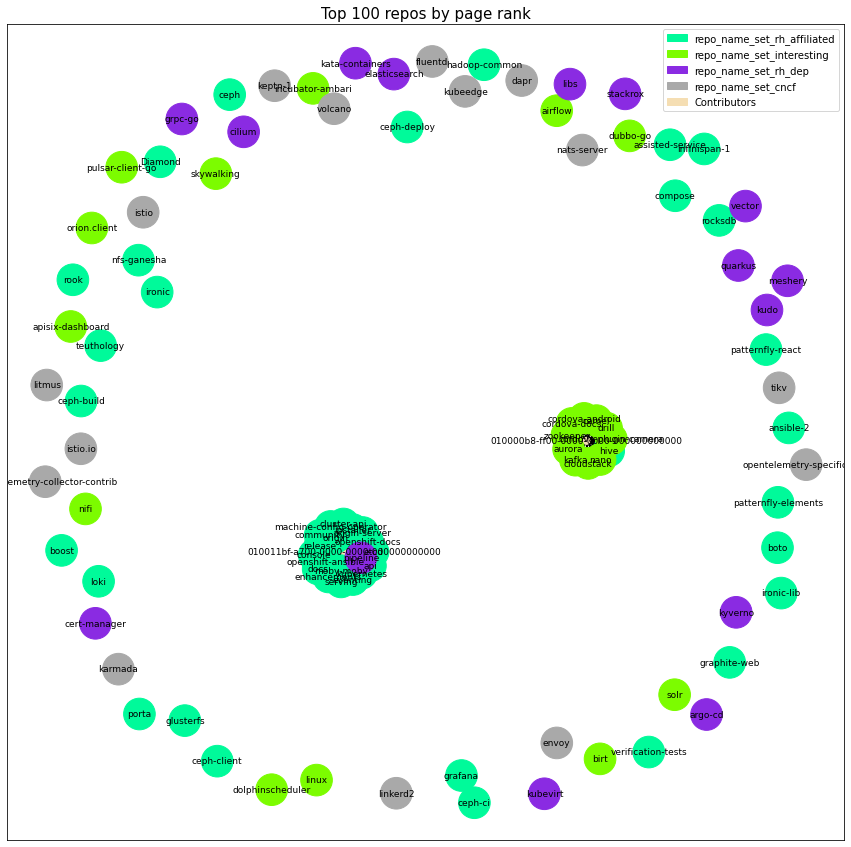

In [48]:
plot_graph(subgraph, repos, 'conditional', t, repo_name_set , True, None, 'k')

***What do we see in this plot?***

We see that there are some repos from all categories that are highly ranked by Pagerank.

Note: The PageRank algorithm measures the importance of nodes by analyzing the quantity and quality of the links that point to it. So if a repository has a lot of contributors and especially if these contributors count as important nodes, they are still ranked high. 

### Betweenness centrality

Betweenness centrality analysis provides information about the node’s importance for an information flow or connectivity of the network. 
This is a good metric for us, as using this we are able to better capture relative importance of repositories. In our case since we start with examples of well-known repos, we can use this algorithm to find other repos which are important in connection to these well-known repos.

In [49]:
G = nx.from_pandas_edgelist(merged_df, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='total_contributions',
                            create_using=nx.Graph())

In [51]:
top_repos, bc, repo_scores = get_betweenness_centrality(G, 100, repos, repo_scores)

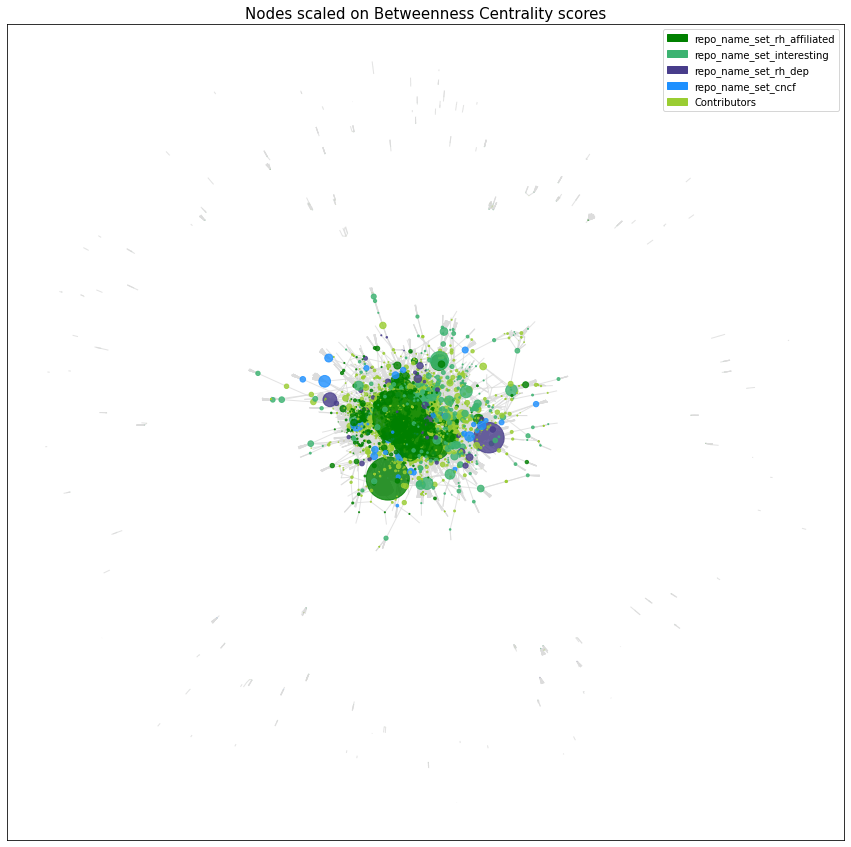

In [52]:
t = "Nodes scaled on Betweenness Centrality scores"
plot_graph(G, repos, 'weighted', t, bc , False, 0.8, "gainsboro")

## Graph Type 2: Nodes as projects edges as contributors

In [53]:
result, common_repo_contri = project_nodes_edges_contributions(merged_df)

For plotting the graph below, we pick the repositories as the nodes and let the shared contributions dictate the edge weights

In [54]:
g = nx.Graph()
g.add_weighted_edges_from(result)

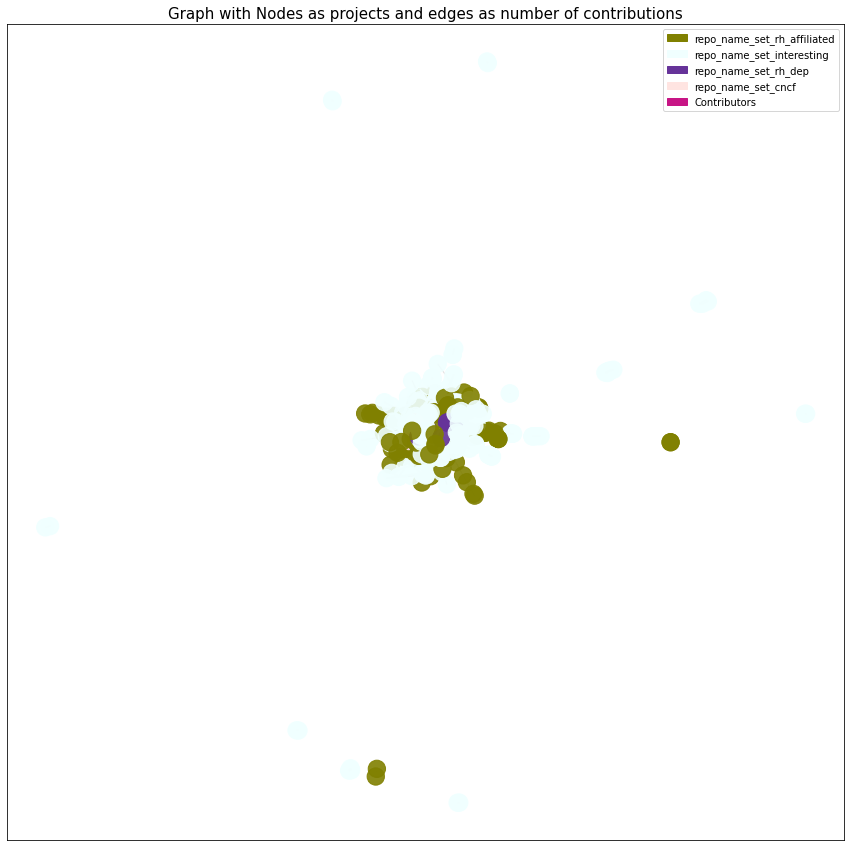

In [55]:
t = "Graph with Nodes as projects and edges as number of contributions"
plot_graph(g, repos, 'equal', t, None , False, 0.9, "gainsboro")

This is a lot of repositories and the graph is hard to read clearly. In this graph representation type, the further a node is to another node, they share less number of shared contributions. Thus, we can elimate some of the node connections or edges which are really long

### Lets eliminate the 30% of the furthest connections

In [56]:
sorted_contribution_dict = dict(sorted(common_repo_contri.items(), key=lambda item: item[1], reverse=True))

In [57]:
tightly_connected_repos = dict(itertools.islice(sorted_contribution_dict.items(), round(0.7*len(sorted_contribution_dict))))

### Community Detection

To get groups of clusters, lets look at larger congregations with more than 10 projects to get a cleaner view into the main networks

In [58]:
graphs = [g.subgraph(c) for c in nx.connected_components(g)]

In [59]:
sub_graphs = []
for g in graphs:
    n = g.nodes()
    if g.number_of_nodes() > 5 and (set(n) & set(repo_name_set_interesting)):
        sub_graphs.append(g)

In [60]:
sub_graphs

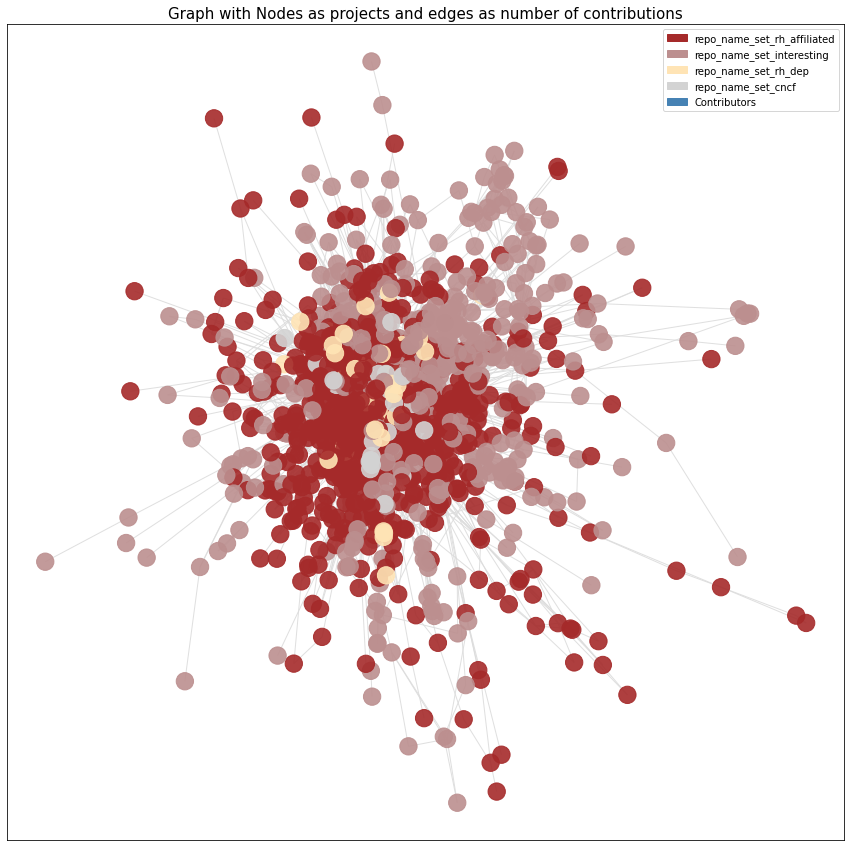

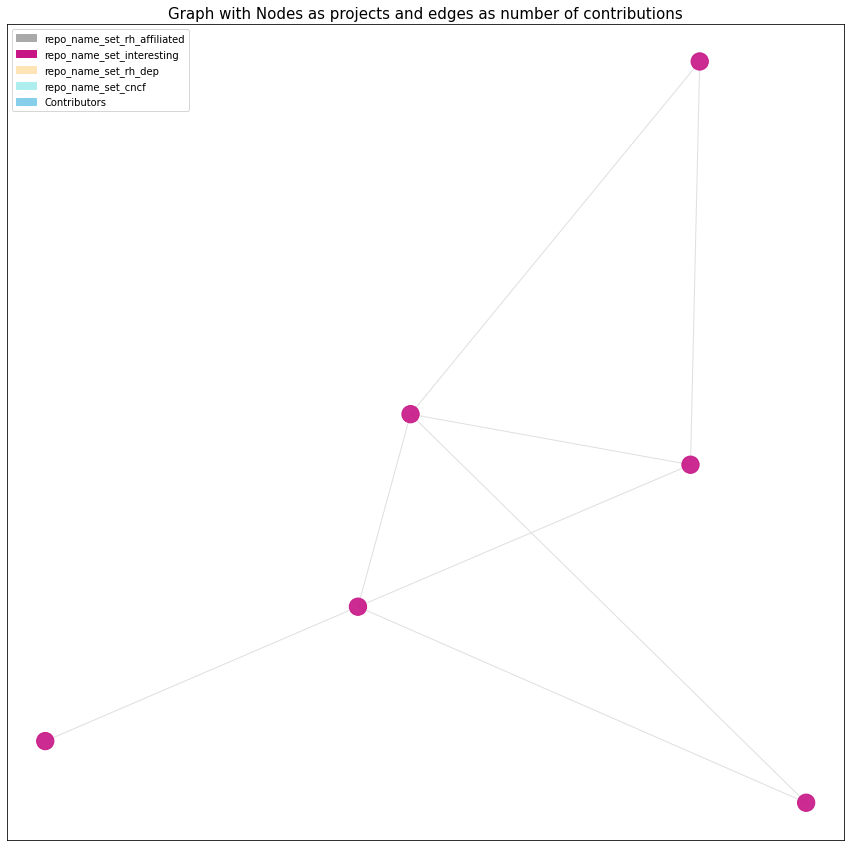

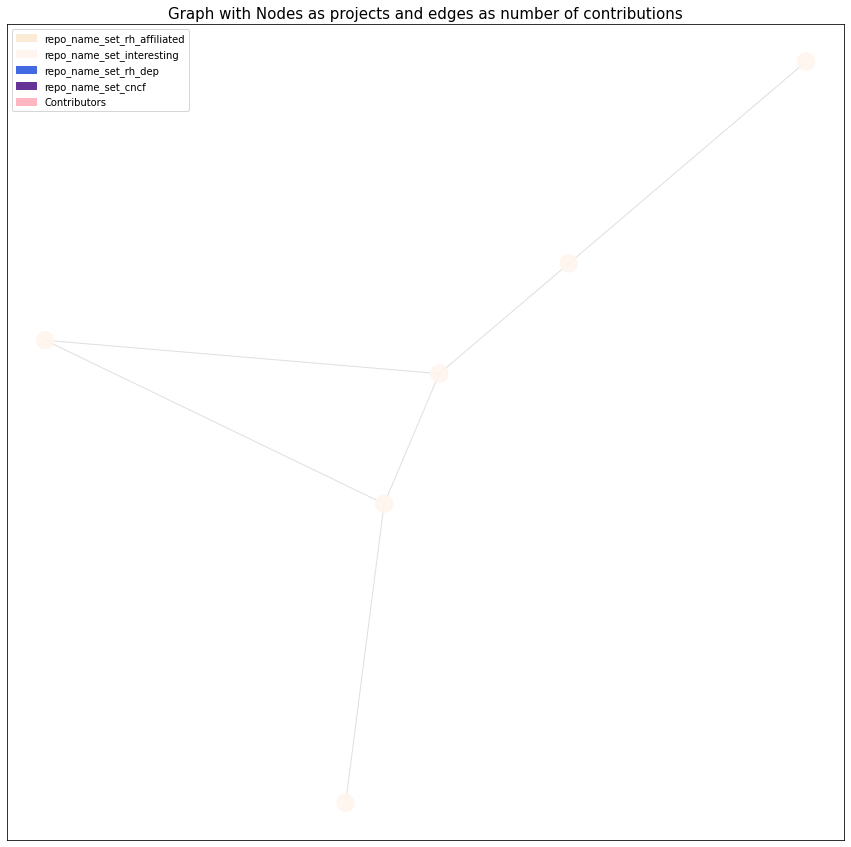

In [61]:
for graph in sub_graphs:
    plot_graph(graph, repos, 'equal', t, None , False, 0.9, "gainsboro")

In [62]:
top_repos, cc, repo_scores = get_closeness_centrality(sub_graphs[0], 100, repos, repo_scores)

In [84]:
repo_scores

,repo,page_rank,betweenness_centrality,closeness_centrality,category,total_score
0,approval-process,0.000628,0.000007,0.307521,repo_name_set_rh_affiliated,0.308155
5,vulnerability-engine,0.003343,0.001269,0.310863,repo_name_set_rh_affiliated,0.315475
12,topological-inventory-frontend,0.000487,0.000008,0.450368,repo_name_set_rh_affiliated,0.450863
13,drift-backend,0.002164,0.000582,0.380466,repo_name_set_rh_affiliated,0.383212
16,insights-schemas-java,0.000811,0.000063,0.557885,repo_name_set_rh_affiliated,0.558759
...,...,...,...,...,...,...
3048,opentelemetry-java,0.008122,0.006772,0.405926,repo_name_set_cncf,0.420820
3049,keylime,0.015278,0.009963,0.624848,repo_name_set_cncf,0.650089
3050,strimzi-kafka-operator,0.015718,0.016667,0.664826,repo_name_set_cncf,0.697211
3051,kubedl,0.003163,0.001330,0.372292,repo_name_set_cncf,0.376784


## Top most interesting repos in each category based on the above scores

In [86]:
repo_scores.dropna(axis=0)

,repo,page_rank,betweenness_centrality,closeness_centrality,category,total_score
0,approval-process,0.000628,0.000007,0.307521,repo_name_set_rh_affiliated,0.308155
5,vulnerability-engine,0.003343,0.001269,0.310863,repo_name_set_rh_affiliated,0.315475
12,topological-inventory-frontend,0.000487,0.000008,0.450368,repo_name_set_rh_affiliated,0.450863
13,drift-backend,0.002164,0.000582,0.380466,repo_name_set_rh_affiliated,0.383212
16,insights-schemas-java,0.000811,0.000063,0.557885,repo_name_set_rh_affiliated,0.558759
...,...,...,...,...,...,...
3048,opentelemetry-java,0.008122,0.006772,0.405926,repo_name_set_cncf,0.420820
3049,keylime,0.015278,0.009963,0.624848,repo_name_set_cncf,0.650089
3050,strimzi-kafka-operator,0.015718,0.016667,0.664826,repo_name_set_cncf,0.697211
3051,kubedl,0.003163,0.001330,0.372292,repo_name_set_cncf,0.376784


In [87]:
def category(col_val, repo_dict):
    for repo_group in repo_dict:  
        if col_val in repo_dict[repo_group]:
            return repo_group

In [88]:
repo_scores['category'] = repo_scores['repo'].apply(lambda row: category(row, repos))

<ipython-input-88-439452805e95>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repo_scores['category'] = repo_scores['repo'].apply(lambda row: category(row, repos))


In [89]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [81]:
def calculate_scores(df):
    df[['page_rank', 'betweenness_centrality', 'closeness_centrality']] = scaler.fit_transform(df[['page_rank', 'betweenness_centrality', 'closeness_centrality']])
    df['total_score'] = df.apply(lambda row: row.page_rank + row.betweenness_centrality + row.closeness_centrality, axis = 1)
    return df

In [82]:
repo_scores = calculate_scores(repo_scores)

<ipython-input-81-60b3e961655e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['page_rank', 'betweenness_centrality', 'closeness_centrality']] = scaler.fit_transform(df[['page_rank', 'betweenness_centrality', 'closeness_centrality']])
/opt/app-root/lib64/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-81-60b3e961655e>:3: SettingWithCopyWarning: 
A value is trying to be set on a

In [83]:
repo_scores

,repo,page_rank,betweenness_centrality,closeness_centrality,category,total_score
0,approval-process,0.000628,0.000007,0.307521,repo_name_set_rh_affiliated,0.308155
5,vulnerability-engine,0.003343,0.001269,0.310863,repo_name_set_rh_affiliated,0.315475
12,topological-inventory-frontend,0.000487,0.000008,0.450368,repo_name_set_rh_affiliated,0.450863
13,drift-backend,0.002164,0.000582,0.380466,repo_name_set_rh_affiliated,0.383212
16,insights-schemas-java,0.000811,0.000063,0.557885,repo_name_set_rh_affiliated,0.558759
...,...,...,...,...,...,...
3048,opentelemetry-java,0.008122,0.006772,0.405926,repo_name_set_cncf,0.420820
3049,keylime,0.015278,0.009963,0.624848,repo_name_set_cncf,0.650089
3050,strimzi-kafka-operator,0.015718,0.016667,0.664826,repo_name_set_cncf,0.697211
3051,kubedl,0.003163,0.001330,0.372292,repo_name_set_cncf,0.376784


In [104]:
top_repos = repo_scores.sort_values("total_score", ascending=False).groupby("category").head(20)

In [105]:
top_repos

,repo,page_rank,betweenness_centrality,closeness_centrality,category,total_score
1886,ansible-2,1.000000,0.654783,0.839384,repo_name_set_rh_affiliated,2.494167
947,release,0.336731,1.000000,1.000000,repo_name_set_rh_affiliated,2.336731
3036,kubernetes,0.320015,0.460634,0.894023,repo_name_set_rh_affiliated,1.674673
653,kubernetes,0.320015,0.460634,0.894023,repo_name_set_rh_affiliated,1.674673
2986,elasticsearch,0.485672,0.328688,0.701940,repo_name_set_rh_dep,1.516300
...,...,...,...,...,...,...
3052,osm,0.017213,0.009549,0.580222,repo_name_set_cncf,0.606984
3021,alertmanager,0.005080,0.002050,0.598292,repo_name_set_cncf,0.605422
3028,mysqld_exporter,0.002686,0.000865,0.599184,repo_name_set_cncf,0.602735
3022,client_golang,0.005629,0.001730,0.593857,repo_name_set_cncf,0.601216


In [110]:
top_repos.loc[top_repos['category'] == 'repo_name_set_rh_affiliated', 'repo']

1886         ansible-2
947            release
3036        kubernetes
653         kubernetes
1854              docs
1891              docs
1262              docs
674          community
1851         community
1858         community
2954         community
1017         community
2962         community
2969         community
1802         community
3011         community
622          moby-moby
497     openshift-docs
1794              ceph
804               etcd
Name: repo, dtype: object

In [107]:
top_repos.loc[top_repos['category'] == 'repo_name_set_interesting', 'repo']

2904                   linux
2693                   camel
2585         cordova-android
2452              cloudstack
2246                 reddeer
2157            microprofile
2583              deltaspike
2512                   kafka
1967                che-docs
2085           jetty.project
2520                 airflow
1992    che-workspace-loader
2801                    nano
2196                     omr
2906                 gitsign
2009         codewind-vscode
2712               zookeeper
2768            cordova-docs
1951         ceylon-lang.org
2895                 stanbol
Name: repo, dtype: object

In [108]:
top_repos.loc[top_repos['category'] == 'repo_name_set_cncf', 'repo']

3010                              istio
3013                           istio.io
3035                            fluentd
3017                              envoy
3050             strimzi-kafka-operator
3001                             litmus
3015                              tools
3004                               tikv
3047    opentelemetry-collector-contrib
3049                            keylime
3012                              proxy
2999                           kubeedge
3039                           kubeedge
3026                        pushgateway
3044            opentelemetry-collector
2997                            karmada
3052                                osm
3021                       alertmanager
3028                    mysqld_exporter
3022                      client_golang
Name: repo, dtype: object

In [109]:
top_repos.loc[top_repos['category'] == 'repo_name_set_rh_dep', 'repo']

2986                      elasticsearch
2923                            meshery
2956                           pipeline
2989                           kubevirt
2968                    kata-containers
2992    hyperconverged-cluster-operator
2913                             cilium
2946                               libs
2990        containerized-data-importer
2919                              kiali
2987                               runc
2961                           operator
2993                   kubevirt-ansible
2970                              tests
2959                           triggers
2940                    deployments-k8s
2942                           stackrox
2920                               kudo
2915                       distribution
2980                                cdi
Name: repo, dtype: object